In [1]:
# change directory to ensure imports and downloads work correctly
import os
os.chdir('..')

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.optimize as spo
import data_processing.primed_utils as primed_utils
from primed_data_processing.arbin_cycler import ArbinBatch

In [589]:
data_array = {}
# for cell_number in (9,10,11,12,1,2,3,4,5,6,7,8):
for cell_number in (9,10,11,12,3,4,13):
    with open(f"aggregate_params/C{cell_number}.npy", "rb") as f:
        data_array[cell_number] = np.load(f, allow_pickle=True)

val_array = {}
for cell_number in (1,2,5,6,7,8,16,14,15):
    with open(f"aggregate_params/C{cell_number}.npy", "rb") as f:
        val_array[cell_number] = np.load(f, allow_pickle=True)

In [601]:
print(val_array[14])
print(val_array[15])

[{1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 100: 0.0, 101: 0.0, 102: 0.0, 103: 0.0, 104: 0.0, 105: 0.0, 106: 0.0, 107: 0.0, 108: 0.0, 109: 0.0, 110: 0.0, 111: 0

In [6]:
def rewrite_dod(data_array):
    for key, data in data_array.items():
        forty_dict = {idx: 0.4 for idx in range(1,max(data[2].keys())+1)}
        eighty_dict = {idx: 0.8 for idx in range(1,max(data[2].keys())+1)}
        if key == 13:
            data[2] = {idx: 0.0 for idx in range(1,max(data[2].keys())+1)}
        if key in (9,12,4):
            data[2] = forty_dict
        else:
            data[2] = eighty_dict

In [7]:
rewrite_dod(data_array)

In [922]:
def model(params, efc, mean_c, mean_dod, t, soh_i):
    a = params[0]
    b = params[1]
    c = params[2]
    d = params[3]
    e = params[4]
    alpha = params[5]
    beta = params[6]
    a_mean_c = np.mean(a * mean_c)
    # print(a_mean_c)
    c_mean_dod = np.mean(c * mean_dod)
    # print(c_mean_dod)
    # print()
    # return soh_i - (a_mean_c * np.exp(b*efc)) + (c_mean_c * np.exp(d*efc)) - alpha * t ** beta
    # soh_i*np.exp(b * efc * c_mean_dod - a_mean_c * (1 - c_mean_dod)) - alpha * t ** beta
    return soh_i*np.exp(b * efc * (c_mean_dod ** d + a_mean_c ** e)) - alpha * t ** beta

def get_window_means(data, cycle, idx, i):
    if idx == 0:
        mean_c = np.array([data[1][cycle], data[1][cycle], data[1][cycle], data[1][cycle]])
        mean_dod = np.array([data[2][cycle], data[2][cycle], data[2][cycle], data[2][cycle]])
    elif idx == 1:
        mean_c = np.array([data[1][cycle-i], data[1][cycle], data[1][cycle], data[1][cycle]])
        mean_dod = np.array([data[2][cycle-i], data[2][cycle], data[2][cycle], data[2][cycle]])
    elif idx == 2:
        mean_c = np.array([data[1][cycle-2*i], data[1][cycle-i], data[1][cycle], data[1][cycle]])
        mean_dod = np.array([data[2][cycle-2*i], data[2][cycle-i], data[2][cycle], data[2][cycle]])
    else:
        mean_c = np.array([data[1][cycle-3*i], data[1][cycle-2*i], data[1][cycle-i], data[1][cycle]])
        mean_dod = np.array([data[2][cycle-3*i], data[2][cycle-2*i], data[2][cycle-i], data[2][cycle]])
    return mean_c, mean_dod

def sim_cell(params, data, cell_number, return_soh=False):
    sse = 0
    est_soh = []
    sse_count = 1

    if cell_number in (13,16):
        rng = range(1,max(data[0].keys())+1)
        i = 1

    if cell_number in (9,10,11,12,1,2,3,4,5,6,7,8):
        rng = range(1,max(data[0].keys())+1,2)
        i = 2

    if cell_number == 14:
        rng = range(152,max(data[0].keys())+1)
        i = 1

    if cell_number == 15:
        rng = range(151,max(data[0].keys())+1)
        i = 1

    soh_i = data[4][list(rng)[0]]

    efc = 0
    for idx, cycle in enumerate(rng):
        efc += data[0][cycle]
        time = data[3][cycle]
        mean_c, mean_dod = get_window_means(data, cycle, idx, i)
        est_soh.append(model(params, efc, mean_c, mean_dod, time, soh_i*100))

        if cycle % 2 != 0 and cycle > 1 and cell_number not in (13,16):
            actual_soh = data[4][cycle]
            sse += ((actual_soh*100 - est_soh[-1]) ** 2)/sse_count
            sse_count += 1
        elif cell_number in (13,16) and cycle > 1:
            actual_soh = data[4][cycle]
            sse += ((actual_soh*100 - est_soh[-1]) ** 2)/sse_count
            sse_count += 1
            
    if return_soh:
        return sse, est_soh
    return sse

In [842]:
print(list(range(0,4))[0])

0


In [685]:
def obj_func(params, data_array, cell_numbers, cycle_fit=False):

    if cycle_fit:
        params = np.append(params, 1.2974e-2)
        params = np.append(params, 0.7)

    sse = 0
    for cell_number in cell_numbers:
        
        data = data_array[cell_number]

        if cell_number in (13,16):
            sse += sim_cell(params, data, cell_number)

        if cell_number in (9,10,11,12,1,2,3,4,5,6,7,8):
            sse += sim_cell(params, data, cell_number)
            
    return sse

In [223]:
obj_func(
    [1e-5,1e-5,1e-5,1e-5,0.7],
    data_array,
    # (9,10,11,12,3,4,13),
    (13,)
)

0.0370890568171278

In [652]:
result = spo.least_squares(
    obj_func,
    # [1e-3,1e-3,1e-3,1e-3,7e-4,0.7],
    (3.217e-02, -1.952e-04,  1.137e+00),#,1.3e-4,0.7),
    args = (
        data_array,
        # (9,10,11,12,3,4,13),
        (9,10,11,12,3,4),
        True
    )
)
print(result)

C:\Users\seanb\AppData\Local\Temp\ipykernel_21316\3116902318.py:64: RuntimeWarning: overflow encountered in scalar power
  sse += ((actual_soh*100 - est_soh[-1]) ** 2)/sse_count
C:\Users\seanb\AppData\Local\Temp\ipykernel_21316\3116902318.py:14: RuntimeWarning: overflow encountered in exp
  return soh_i*np.exp(b * efc * (c_mean_dod + a_mean_c * (1-c_mean_dod))) - alpha * t ** beta


     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 7.998e+01]
           x: [ 3.217e-02 -1.641e-04  1.137e+00]
        cost: 3198.38916399801
         jac: [[-6.318e+01 -6.227e+02  3.776e+00]]
        grad: [-5.053e+03 -4.981e+04  3.020e+02]
  optimality: 49806.10641382212
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 22
        njev: 11


In [1014]:
global_result = spo.dual_annealing(
    obj_func,
    bounds = (
        (1e-7, 1e-1),
        (-1e-1, -1e-5),
        (1e-3, 1.3),
        (1,3),
        (0,1),
        (1e-3, 1e-1),
        (0.4, 0.8)
    ),
    args=(
        data_array,
        (9,10,11,12,3,4,13),
        # (9,12,4),
        False
    ),
    # maxiter = 10000,
    # initial_temp = 8000,
)

In [1015]:
global_result

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 26.732662433666096
       x: [ 1.465e-04 -6.839e-02  1.088e-01  2.899e+00  9.121e-01
            1.000e-01  4.746e-01]
     nit: 1000
    nfev: 15081
    njev: 135
    nhev: 0

In [1038]:
# (9,10,11,12,3,4,13)
# (1,2,5,6,7,8,16)
cell = 16
data = val_array
x = np.append(global_result.x, 1.2974e-2)
x = np.append(x, 0.7)
sse, soh = sim_cell([ 4.91441030e-04, -2.98808476e-03,  3.09008644e-01,  2.80785041e+00,
        6.12442315e-01,  1.00000000e-01,  4.61330493e-01], data[cell], cell, True)

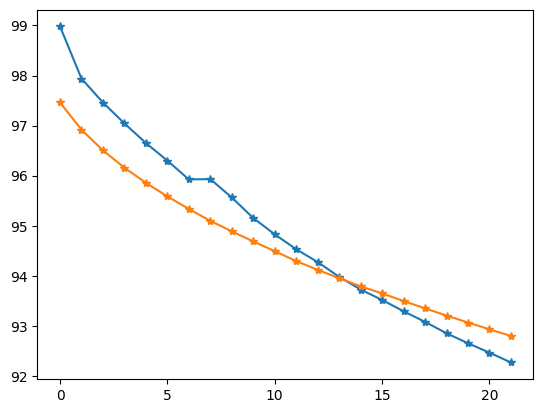

In [1039]:
if cell == 14:
    plt.plot([val*100 for idx, val in data[cell][4].items() if idx >=152], marker='*')
elif cell == 15:
    plt.plot([val*100 for idx, val in data[cell][4].items() if idx >=151], marker='*')
else:
    plt.plot(np.array(list(data[cell][4].values()))*100, marker='*')
if cell in (9,10,11,12,1,2,3,4,5,6,7,8):
    plt.plot(soh[:], marker='*')
    pass
else:
    plt.plot(soh, marker='*')

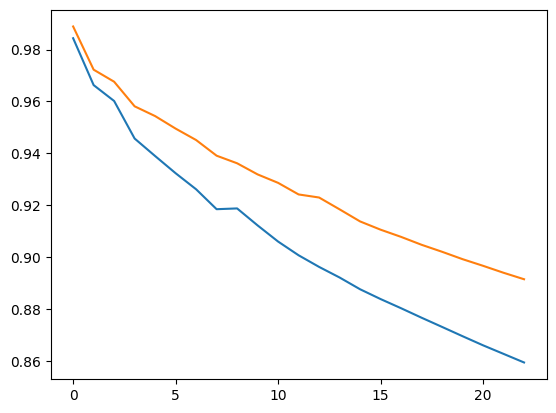

In [602]:
# out = np.cumsum(list(data_array[cell][0].values()))
# plt.plot(out[::2], marker='*')
# plt.plot(list(data[9][1].values())[2::2])
plt.plot(val_array[14][-1].values())
plt.plot(val_array[15][-1].values())
# data_array[10]

In [1037]:
print(soh[-1])
print(list(data[cell][4].values())[-1])

84.97531567877415
0.8914535045
